In [1]:

import torch
# from tbparse import SummaryReader
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import yaml
from tqdm import tqdm
# import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import \
    EventAccumulator
from tbparse import SummaryReader
from functools import reduce
# from tqdm.auto import tqdm  # for notebooks
from tqdm.notebook import tqdm
tqdm.pandas()
plt.rcParams.update({'font.size': 14})

# Overview: Load tensorboard files and plot them

Notebook to load in events files and plot them / save etc

# Models and tasks completed

## Sequence classification

<!-- produce checklist -->
- 

## function development

In [2]:
# mapping of custom models to model names

def get_model_name(model_name_or_path:str) -> str:
    if "saved_models" in model_name_or_path:
        if "declutr" in model_name_or_path:
            if "few_epoch" in model_name_or_path:
                if "span_comparison" in model_name_or_path:
                    model_name = model_name_or_path.split("/")[9] + "/declutr/" + model_name_or_path.split("/")[-3]
                else:
                    model_name = model_name_or_path.split("/")[8] + "/declutr/" + model_name_or_path.split("/")[-3]

            else:
                model_name = model_name_or_path.split("/")[7] + "/declutr/" + model_name_or_path.split("/")[-3]
        elif "contrastive" in model_name_or_path or "custom_pretraining" in model_name_or_path:
            model_name = model_name_or_path.split("/")[7]
        elif "simcse" in model_name_or_path:# change this to be dynamic
            model_name = "simcse-mimic"
        else:
            model_name = model_name_or_path.split("/")[7]
    else:    
        model_name = model_name_or_path.split("/")[-1]
    
    return model_name

# an explicit mapping for paper model names

long_model_name_mappings = {
    "roberta-base": "RoBERTa-base",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1": "RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1_weighted":"RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted":"RoBERTa-mimic-note-two-epoch",
    "mimic-roberta-base": "RoBERTa-mimic",
    "roberta-base-2_anch_2_pos_min_1024": "RoBERTa-mimic-DeCLUTR",
    "roberta-base-cris": "RoBERTa-cris",
    "roberta-base-declutr-2_anch_2_pos_min_64":"RoBERTA-cris-DeCLUTR",
    "roberta-base-cris-note-custom_pretraining_1":"RoBERTa-cris-note",
    "Bio_ClinicalBERT": "Bio-ClinicalBERT",
    "sts_trf_roberta": "ST-TRF-RoBERTa",
    "all-mpnet-base-v2 ": "all-mpnet-base-v2"
                           
                            
    }

# task name mappings

task_name_mappings = {"icd9-triage-no-category-in-text": "ICD9-Triage",
                      "icd9-triage": "ICD9-Triage",}

In [3]:
def get_configs(modeldir):
    # try open but skip if doesn't exist
    try:
        #TODO - fix this to pass logs_dir as an argument
        with open(logs_dir + modeldir + '/config.yaml') as f:        
            configs= yaml.load(f, Loader=yaml.FullLoader)
    except IOError as e:
        print(e)
        configs = {}
    configs['dir_name'] = modeldir
    return configs

In [159]:
# def get_trainer_args(modeldir):
#     with open(logdir + modeldir + '/all_trainer_args.yaml') as f:
#         trainer_args= yaml.load(f, Loader=yaml.FullLoader)
#         trainer_args['dir_name'] = modeldir
#     return trainer_args

In [4]:
# function to read in event files given a logdir and return a dataframe with config merged

def read_tb_files(logdir):
    
    # first use summary reader
    reader = SummaryReader(logdir, extra_columns={'dir_name'})
    df = reader.scalars
    
    # now load in config files

    config_list = df["dir_name"].drop_duplicates().progress_apply(lambda x: get_configs(x))
    config_df = pd.DataFrame.from_records(config_list)
    merged_df = pd.merge(df, config_df, on='dir_name')
    
    # we want to replace few_shot_n nan values with few_shot_n = "full"
    merged_df['few_shot_n'] = merged_df['few_shot_n'].fillna(250)
    
    # replace task name with mapping using replace function 
    merged_df['task'] = merged_df['task'].replace(task_name_mappings)

    # for now drop any that did not get a model name back i.e. config wasn't available
    merged_df = merged_df[merged_df['model_name_or_path'].notna()]

    # use model_name_or_path to get model name
    merged_df['Model name'] = merged_df['model_name_or_path'].progress_apply(lambda x: get_model_name(x))
    
    
    return merged_df

### debugging

In [161]:
logdir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/'

reader = SummaryReader(logdir, extra_columns={'dir_name'})
df = reader.scalars


In [162]:
config_list = df["dir_name"].drop_duplicates().apply(lambda x: get_configs(x))
config_df = pd.DataFrame.from_records(config_list)
df = pd.merge(df, config_df, on='dir_name')

In [163]:
df.peft_method.value_counts()

peft_method
LORA             41642
PREFIX_TUNING     2412
PROMPT_TUNING     2412
P_TUNING          2412
Full              2088
Name: count, dtype: int64

## Load in events files



In [5]:
logs_dir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/'
logs_df = read_tb_files(logs_dir)

  0%|          | 0/292 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2010-RE/fewshot_16/bio-mobilebert/LORA/27-07-2023--16-18/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2010-RE/fewshot_16/bio-mobilebert/LORA/27-07-2023--16-27/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2010-RE/fewshot_32/bio-mobilebert/LORA/27-07-2023--16-21/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2010-RE/full/tiny-biobert/PROMPT_TUNING/25-07-2023--10-01/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2014-NER/full/Bio_ClinicalBERT/Full/24-07-2023--11-47/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2014-NER/full/bio-mobilebert/LORA/25-07-2023--15-36/config.yaml'
[Errno 2] No such file or dir

  0%|          | 0/145286 [00:00<?, ?it/s]

### investigate files

In [165]:
logs_df.head()

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,data_dir,dropout,eight_bit_training,...,accumulate_grad_batches,classifier_learning_rate,encoder_learning_rate,eval_accumulation_steps,gpu_idx,max_steps,model_type,training_size,custom_model_name,Model name
0,1437,eval/accuracy,0.984213,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
1,2874,eval/accuracy,0.988822,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
2,4311,eval/accuracy,0.990410,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
3,5748,eval/accuracy,0.991725,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
4,7185,eval/accuracy,0.991706,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert


In [166]:
logs_df.columns

Index(['step', 'tag', 'value', 'dir_name', 'cache_dir', 'ckpt_save_dir',
       'combined_val_test_sets', 'data_dir', 'dropout', 'eight_bit_training',
       'eval_batch_size', 'eval_data_dir', 'eval_every_steps',
       'eval_few_shot_n', 'evaluation_strategy', 'fast_dev_run', 'few_shot_n',
       'label_col', 'label_name', 'loader_workers', 'log_every_steps',
       'log_save_dir', 'max_epochs', 'max_length', 'metric_mode',
       'model_name_or_path', 'monitor', 'no_cuda', 'optimizer', 'patience',
       'peft_method', 'pretrained_models_dir', 'save_every_steps',
       'saving_strategy', 'sensitivity', 'task', 'task_to_keys', 'task_type',
       'test_file', 'text_col', 'train_batch_size', 'training_data_dir',
       'training_file', 'validation_file', 'warmup_steps', 'remove_columns',
       'text_column', 'accumulate_grad_batches', 'classifier_learning_rate',
       'encoder_learning_rate', 'eval_accumulation_steps', 'gpu_idx',
       'max_steps', 'model_type', 'training_size', '

In [167]:
logs_df.model_name_or_path.unique()

array(['nlpie/distil-biobert',
       '/mnt/sdc/niallt/saved_models/language_modelling/mimic/mimic-roberta-base/sampled_250000/22-12-2022--12-45/checkpoint-100000/',
       '/mnt/sdc/niallt/saved_models/declutr/mimic/few_epoch/mimic-roberta-base/2_anch_2_pos_min_1024/transformer_format/',
       'roberta-base', 'emilyalsentzer/Bio_ClinicalBERT',
       'michiyasunaga/LinkBERT-base', 'decapoda-research/llama-7b-hf',
       'ybelkada/falcon-7b-sharded-bf16',
       'michiyasunaga/BioLinkBERT-base', 'nlpie/bio-mobilebert',
       '/mnt/sdc/niallt/saved_models/language_modelling/mimic/roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted/sampled_250000/07-07-2023--08-30/checkpoint-30000/',
       'nlpie/tiny-biobert'], dtype=object)

In [168]:
logs_df["Model name"].unique()

array(['distil-biobert', 'mimic-roberta-base',
       'mimic-roberta-base/declutr/2_anch_2_pos_min_1024', 'roberta-base',
       'Bio_ClinicalBERT', 'LinkBERT-base', 'llama-7b-hf',
       'falcon-7b-sharded-bf16', 'BioLinkBERT-base', 'bio-mobilebert',
       'roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted',
       'tiny-biobert'], dtype=object)

In [169]:
# check unique tasks 
logs_df.task.value_counts()

task
icd9-triage-no-category-in-text    21356
mimic-mp                           11676
i2b2-2014-NER                       8868
mimic-los                           7500
icd9-triage                         1566
Name: count, dtype: int64

In [170]:
# check unique tags
logs_df.tag.unique()

array(['eval/accuracy', 'eval/f1', 'eval/loss', 'eval/precision',
       'eval/recall', 'eval/runtime', 'eval/samples_per_second',
       'eval/steps_per_second', 'train/epoch', 'train/learning_rate',
       'train/loss', 'train/total_flos', 'train/train_loss',
       'train/train_runtime', 'train/train_samples_per_second',
       'train/train_steps_per_second', 'eval/f1_macro',
       'eval/f1_weighted', 'eval/roc_auc_macro'], dtype=object)

In [171]:
# check unique few shot values
logs_df.few_shot_n.unique()

array([250.,  16., 200.,  32.,  64.])

In [172]:
metrics = ['f1','precision','recall','accuracy']
logs_df[logs_df['tag'].str.contains('|'.join(metrics))]

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,data_dir,dropout,eight_bit_training,...,accumulate_grad_batches,classifier_learning_rate,encoder_learning_rate,eval_accumulation_steps,gpu_idx,max_steps,model_type,training_size,custom_model_name,Model name
0,1437,eval/accuracy,0.984213,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
1,2874,eval/accuracy,0.988822,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
2,4311,eval/accuracy,0.990410,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
3,5748,eval/accuracy,0.991725,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
4,7185,eval/accuracy,0.991706,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49329,2124,eval/recall,0.565446,mimic-mp/full/roberta-base/LORA/17-07-2023--11-34,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,roberta-base
49330,3186,eval/recall,0.610209,mimic-mp/full/roberta-base/LORA/17-07-2023--11-34,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,roberta-base
49331,4248,eval/recall,0.603068,mimic-mp/full/roberta-base/LORA/17-07-2023--11-34,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,roberta-base
49332,5310,eval/recall,0.591155,mimic-mp/full/roberta-base/LORA/17-07-2023--11-34,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,roberta-base


In [173]:
# i think few_shot_n values of nan are for the full training set
# check example of one with na 
logs_df[logs_df.few_shot_n.isna()].head()

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,data_dir,dropout,eight_bit_training,...,accumulate_grad_batches,classifier_learning_rate,encoder_learning_rate,eval_accumulation_steps,gpu_idx,max_steps,model_type,training_size,custom_model_name,Model name


## Pull out metrics etc

In [6]:
def extract_metric(logs_df,
                   mode = "all",
                    metrics = "all",                     
                    sample_sizes = None, 
                    save_csv = False):
    '''
    Function to pull certain specified features from the full logs dataframes
    
    Args: 
        mode: The dataset you want metrics for e.g. train/valid/test            
        metrics: The metric you want to look at e.g. f1, precision etc.

        tasks: list of specific tasks to extract - None by default means all tasks
        analysis: baseline is just the main experiments before any hyperparam search or sensitivty analysis. sensitivity for that analysis and optimized for the optimised experiment

    Returns: 
        dataframe containing organised and subsetted metrics based on arguments provided
    '''


    if metrics == "all" and mode == "all":
        return logs_df
    
    # now for cases where mode is specific        
    elif metrics == "all" and mode != "all": 
        metrics_df = logs_df[logs_df["tag"].str.contains(mode)]            
    
    
    # cases where metric is specific but mode is all
    elif metrics != "all" and mode == "all":
        metrics_df =  logs_df[logs_df["tag"].str.contains(metrics)]
    
    # now for cases where both metric and mode are specific
    elif metrics != "all" and mode != "all":
        
        # handle multiple specific metrics
        metrics_df = logs_df[logs_df['tag'].str.contains('|'.join(metrics)) & (logs_df["tag"].str.contains(mode))]
        # metrics_df = logs_df[(logs_df["tag"].str.contains(metrics)) & (logs_df["tag"].str.contains(mode))]    

    
    
    return metrics_df

In [62]:
metrics_df = extract_metric(logs_df, mode = "eval", metrics = ["f1","accuracy"], sample_sizes = [999], save_csv = False)

In [64]:
metrics_df.task_type.unique()

array(['TOKEN_CLS', 'SEQ_CLS'], dtype=object)

In [65]:
def produce_results_table(logs_df,
                            metric = "f1_macro", # do not use all here
                            mode = "eval",
                            groupby_list = ["Model name", "few_shot_n"],
                            task_type = "SEQ_CLS", # | TOKEN_CLS
                            value_aggregate_method = "mean",
                            log_collection = "all", # | span
                            plm = "Frozen" # | Finetuned
                                ):

        ''' 
        Function to produce a semi-formatted table based on a metric of interest grouped by key features
        '''
        # extract the metrics based on params
        
        
        
        
        
        tb_metrics = extract_metric( logs_df,  metrics = metric,
                                            mode = mode)
        
        # drop rows that are != task_type and if task_type is not specified then keep all
        if task_type is not None:
            
            tb_metrics = tb_metrics[tb_metrics['task_type'] == task_type]

        # remove eval from the tag column
        tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"{mode}/",'')
         # # replace sample sizes of 250 to "full"
        # tb_metrics['Sample size'] = tb_metrics['Sample size'].replace(250,"full")        
        
        grouped_metrics = (tb_metrics.pivot_table(index=groupby_list, 
                    columns='tag', 
                    values='value',
                    aggfunc=value_aggregate_method)
                    .reset_index())
        
        
        

        return grouped_metrics.reset_index() # remove reset_index if it breaks anything

Below will retrieve all metrics of choice for each task and return the max

In [67]:
cls_results_df = produce_results_table(logs_df, 
                                        metric = ["f1",
                                                  "accuracy",
                                                  "precision",
                                                  "recall",
                                                  "auc"],
                                        mode = "eval",
                                        groupby_list = ["Model name", "task","few_shot_n", "peft_method"],
                                        task_type = "SEQ_CLS",
                                        value_aggregate_method = "max",
                                        )

In [68]:
cls_results_df.task.unique()

array(['ICD9-Triage', 'mimic-mp', 'i2b2-2010-RE', 'mimic-los', 'mednli'],
      dtype=object)

In [34]:
cls_results_df.columns

Index(['index', 'Model name', 'task', 'few_shot_n', 'peft_method', 'accuracy',
       'f1', 'f1_macro', 'f1_micro', 'f1_weighted', 'precision', 'recall',
       'roc_auc_macro'],
      dtype='object', name='tag')

In [11]:
cls_results_df.head()

tag,index,Model name,task,few_shot_n,peft_method,accuracy,f1,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro
0,0,BioLinkBERT-base,ICD9-Triage,250.0,LORA,0.949904,NaN,0.878210,NaN,0.949508,0.889395,0.878539,0.994473
1,1,BioLinkBERT-base,mimic-mp,250.0,LORA,0.900163,NaN,0.651606,NaN,0.881659,0.760256,0.623279,0.827994
2,2,Bio_ClinicalBERT,ICD9-Triage,16.0,LORA,0.332370,NaN,0.165953,NaN,0.366077,0.408334,0.212891,0.691148
3,3,Bio_ClinicalBERT,ICD9-Triage,16.0,PREFIX_TUNING,0.445408,NaN,0.263398,NaN,0.482772,0.413669,0.323699,0.756371
4,4,Bio_ClinicalBERT,ICD9-Triage,16.0,PROMPT_TUNING,0.257225,NaN,0.122949,NaN,0.271304,0.381222,0.179832,0.642394


In [19]:
cls_results_df.query("few_shot_n < 250").drop_duplicates(subset=[ "Model name", "task","peft_method"])

tag,index,Model name,task,few_shot_n,peft_method,accuracy,f1,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro
2,2,Bio_ClinicalBERT,ICD9-Triage,16.0,LORA,0.332370,NaN,0.165953,NaN,0.366077,0.408334,0.212891,0.691148
3,3,Bio_ClinicalBERT,ICD9-Triage,16.0,PREFIX_TUNING,0.445408,NaN,0.263398,NaN,0.482772,0.413669,0.323699,0.756371
4,4,Bio_ClinicalBERT,ICD9-Triage,16.0,PROMPT_TUNING,0.257225,NaN,0.122949,NaN,0.271304,0.381222,0.179832,0.642394
5,5,Bio_ClinicalBERT,ICD9-Triage,16.0,P_TUNING,0.465960,NaN,0.162987,NaN,0.411112,0.207918,0.221117,0.631574
22,22,Bio_ClinicalBERT,i2b2-2010-RE,16.0,LORA,0.291419,NaN,0.064160,0.291419,0.413655,0.137098,0.126719,0.548103
34,34,Bio_ClinicalBERT,mimic-los,32.0,LORA,0.321795,NaN,0.238515,0.321795,0.270808,0.264064,0.260568,0.530735
38,38,Bio_ClinicalBERT,mimic-mp,16.0,LORA,0.859006,NaN,0.495562,0.859006,0.833357,0.516960,0.541495,0.563574
41,41,LinkBERT-base,ICD9-Triage,16.0,LORA,0.284200,NaN,0.146043,NaN,0.311927,0.221884,0.196830,0.601291
42,42,LinkBERT-base,ICD9-Triage,16.0,PREFIX_TUNING,0.504496,NaN,0.125795,NaN,0.338341,0.156497,0.279840,0.752841
43,43,LinkBERT-base,ICD9-Triage,16.0,PROMPT_TUNING,0.125562,NaN,0.041781,NaN,0.055271,0.164830,0.146329,0.594512


In [61]:
cls_results_df.task.unique()

array(['ICD9-Triage', 'mimic-mp', 'i2b2-2010-NER', 'i2b2-2010-RE',
       'i2b2-2012-NER', 'i2b2-2014-NER', 'mimic-los', 'mednli'],
      dtype=object)

In [69]:
from itertools import combinations, product, chain

models = cls_results_df["Model name"].unique()
tasks = cls_results_df["task"].unique()
pefts = cls_results_df["peft_method"].unique()

In [70]:
len(models), len(tasks), len(pefts)

(13, 5, 5)

In [75]:
# find all combinations of models, tasks , pefts using itertools combinations

def cartesian_product(arr1, arr2):
 
    # return the list of all the computed tuple
    # using the product() method
    return list(product(arr1, arr2))

def get_remaining_experiments(results_df):
    
    # get all the experiments that have been run
    # get all the combinations of models, tasks, pefts
    # get all the combinations of models, tasks, pefts that have been run
    # get the difference between the two sets
    # return the difference    
    
    
    models = results_df['Model name'].unique()
    tasks = results_df['task'].unique()
    pefts = results_df['peft_method'].unique()
    
    combos = cartesian_product(cartesian_product(models, tasks), pefts)
    combos = [c[0]+(c[1],) for c in combos]
    
    new_df = cls_results_df.set_index([ "Model name", "task","peft_method"])
    print(f'Completed tasks: {len(new_df.index.to_list())}')
    pending_tasks = set(combos).difference(set(new_df.index.to_list()))
    print(f'Pending tasks: {len(pending_tasks)}')
    
    
    return pending_tasks

In [77]:
pending_tasks = get_remaining_experiments(cls_results_df)

Completed tasks: 221
Pending tasks: 241


In [78]:
print(pending_tasks)

{('falcon-7b-sharded-bf16', 'ICD9-Triage', 'PREFIX_TUNING'), ('tiny-biobert', 'ICD9-Triage', 'PROMPT_TUNING'), ('tiny-biobert', 'mednli', 'P_TUNING'), ('falcon-7b-sharded-bf16', 'mimic-mp', 'PROMPT_TUNING'), ('roberta-base', 'mednli', 'PREFIX_TUNING'), ('bio-mobilebert', 'mimic-los', 'PROMPT_TUNING'), ('tiny-biobert', 'mednli', 'LORA'), ('Clinical-Longformer', 'mednli', 'PROMPT_TUNING'), ('llama-7b-hf', 'i2b2-2010-RE', 'PROMPT_TUNING'), ('LinkBERT-base', 'mednli', 'Full'), ('mimic-roberta-base/declutr/2_anch_2_pos_min_1024', 'i2b2-2010-RE', 'PREFIX_TUNING'), ('LinkBERT-base', 'mimic-mp', 'PREFIX_TUNING'), ('mimic-roberta-base', 'mimic-los', 'Full'), ('BioLinkBERT-base', 'mimic-los', 'Full'), ('falcon-7b-sharded-bf16', 'ICD9-Triage', 'Full'), ('roberta-base', 'mimic-mp', 'P_TUNING'), ('roberta-base', 'mimic-los', 'PROMPT_TUNING'), ('roberta-base', 'mednli', 'Full'), ('llama-7b-hf', 'mimic-los', 'P_TUNING'), ('roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted', 'mimic-los',

In [48]:
combos = cartesian_product(cartesian_product(models, tasks), pefts)
combos = [c[0]+(c[1],) for c in combos]

In [60]:
new_df = cls_results_df.set_index([ "Model name", "task","peft_method"])
print(f'Completed tasks: {len(new_df.index.to_list())}')
pending_tasks = set(combos).difference(set(new_df.index.to_list()))
print(f'Pending tasks: {len(pending_tasks)}')
print(pending_tasks)

Completed tasks: 266
Pending tasks: 431
{('BioLinkBERT-base', 'i2b2-2012-NER', 'PROMPT_TUNING'), ('falcon-7b-sharded-bf16', 'mimic-mp', 'PROMPT_TUNING'), ('bio-mobilebert', 'mimic-los', 'PROMPT_TUNING'), ('mimic-roberta-base/declutr/2_anch_2_pos_min_1024', 'i2b2-2010-RE', 'PREFIX_TUNING'), ('BioLinkBERT-base', 'mimic-los', 'Full'), ('tiny-biobert', 'i2b2-2014-NER', 'P_TUNING'), ('BioLinkBERT-base', 'ICD9-Triage', 'PROMPT_TUNING'), ('Clinical-Longformer', 'ICD9-Triage', 'PREFIX_TUNING'), ('Bio_ClinicalBERT', 'mednli', 'PREFIX_TUNING'), ('mimic-roberta-base', 'i2b2-2010-RE', 'PREFIX_TUNING'), ('mimic-roberta-base/declutr/2_anch_2_pos_min_1024', 'i2b2-2010-NER', 'PREFIX_TUNING'), ('all-mpnet-base-v2', 'i2b2-2012-NER', 'PROMPT_TUNING'), ('Clinical-Longformer', 'ICD9-Triage', 'Full'), ('Bio_ClinicalBERT', 'mednli', 'Full'), ('distil-biobert', 'i2b2-2014-NER', 'PROMPT_TUNING'), ('BioLinkBERT-base', 'mimic-mp', 'P_TUNING'), ('mimic-roberta-base', 'i2b2-2010-RE', 'Full'), ('mimic-roberta-base/

In [18]:
cls_results_df.query("few_shot_n == 250").drop_duplicates(subset=[ "Model name", "task",])

tag,index,Model name,task,few_shot_n,peft_method,accuracy,f1,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro
0,0,BioLinkBERT-base,ICD9-Triage,250.0,LORA,0.949904,NaN,0.878210,NaN,0.949508,0.889395,0.878539,0.994473
1,1,BioLinkBERT-base,mimic-mp,250.0,LORA,0.900163,NaN,0.651606,NaN,0.881659,0.760256,0.623279,0.827994
18,18,Bio_ClinicalBERT,ICD9-Triage,250.0,Full,0.951188,NaN,0.887849,0.951188,0.951850,0.886596,0.890325,0.993977
20,20,Bio_ClinicalBERT,i2b2-2010-NER,250.0,Full,0.937673,0.843558,NaN,NaN,NaN,0.841821,0.852396,NaN
27,27,Bio_ClinicalBERT,i2b2-2010-RE,250.0,Full,0.936651,NaN,0.636292,0.936651,0.934578,0.770436,0.613105,0.981500
30,30,Bio_ClinicalBERT,i2b2-2012-NER,250.0,Full,0.914369,0.841927,NaN,NaN,NaN,0.835017,0.853659,NaN
32,32,Bio_ClinicalBERT,i2b2-2014-NER,250.0,Full,0.996175,0.962993,NaN,NaN,NaN,0.968270,0.957774,NaN
37,37,Bio_ClinicalBERT,mimic-los,250.0,Full,0.443862,NaN,0.422290,0.443862,0.438665,0.461359,0.415032,0.704566
39,39,Bio_ClinicalBERT,mimic-mp,250.0,Full,0.894662,NaN,0.657207,0.894662,0.878174,0.708106,0.647766,0.827532
40,40,Clinical-Longformer,ICD9-Triage,250.0,LORA,0.971098,NaN,0.938700,0.971098,0.970939,0.948225,0.938561,0.997160


In [24]:
# cls_results_df.query("`Model name` == 'roberta-base' & task == @task")

In [27]:
cls_results_df.query("`Model name` == 'roberta-base' & task == @task & few_shot_n == 250")

tag,index,Model name,task,few_shot_n,peft_method,accuracy,f1_macro


### Example plot of f1 macro for specific task and model versus PEFT method 

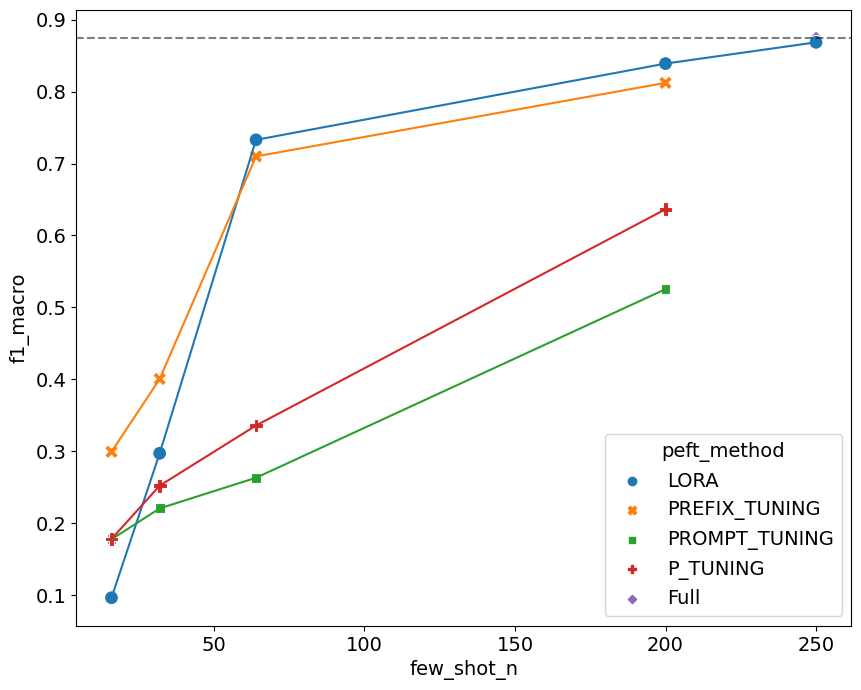

<Figure size 1200x1000 with 0 Axes>

In [13]:
# plot the f1 for one model across few shot sizes and peft method

# some plot params
        # now set x_tick_labels to be used later

# now we want string versions of these to set to xtick labels

task = "ICD9-Triage"

sample_sizes = sorted(set(cls_results_df['few_shot_n'].unique()))
sample_size_x_ticks = [str(x) for x in sample_sizes]

# scatter plot for roberta base vs few shot n with hue as peft method
# plt.figure(figsize=(12,10))

fig, ax = plt.subplots(figsize=(10,8))
g = sns.scatterplot(data = cls_results_df.query("`Model name` == 'roberta-base' & task == @task"),
                    x = "few_shot_n",
                    y = "f1_macro",
                    hue = "peft_method",
                    style = "peft_method",
                    s = 100, ax = ax)

# do same again with point plot

plt.figure(figsize=(12,10))
g = sns.lineplot(data = cls_results_df.query("`Model name` == 'roberta-base' & task == @task"),
                        x = "few_shot_n",
                        y = "f1_macro",
                        hue = "peft_method",
                        ax =ax, 
                        legend = False
)


# draw a horizontal line for the full training set and set at value of peft method with full training set
# and set to same plot as above


ax.axhline(y=cls_results_df.query("`Model name` == 'roberta-base' & task == @task & few_shot_n == 250")["f1_macro"].values[0], color='black', linestyle='--', alpha = 0.5)



           

### Compare multiple models at full sample size

In [16]:
# set models of interest

models_of_interest = ["roberta-base", "Bio_ClinicalBERT", "mimic-roberta-base", "bio-mobilebert", "distil-biobert"]

<Figure size 1200x1000 with 0 Axes>

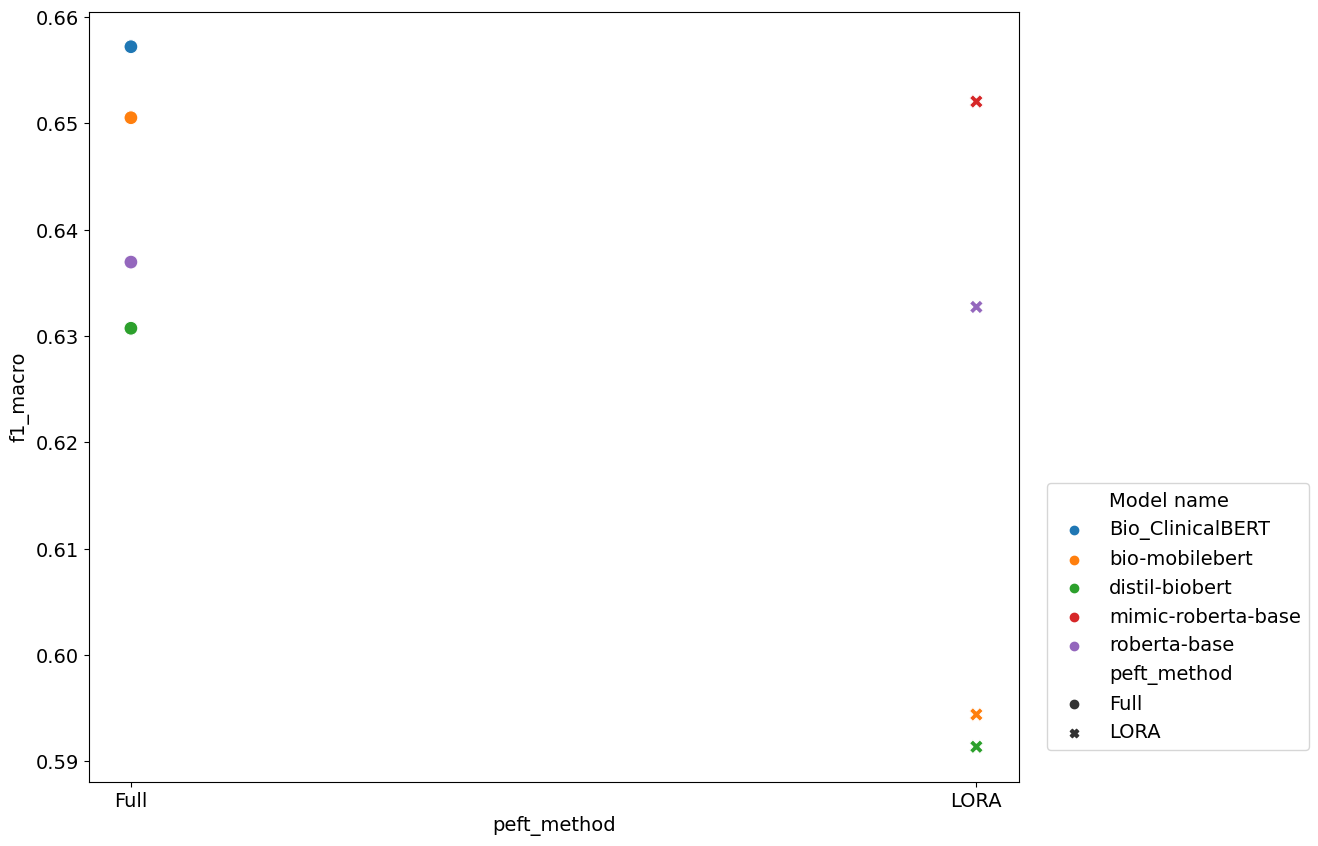

<Figure size 1200x1000 with 0 Axes>

In [17]:
task = "mimic-mp"


# scatter plot for roberta base vs few shot n with hue as peft method
plt.figure(figsize=(12,10))

fig, ax = plt.subplots(figsize=(12,10))
g = sns.scatterplot(data = cls_results_df.query("few_shot_n == 250 & task == @task & `Model name` in @models_of_interest"),
                    x = "peft_method",
                    y = "f1_macro",
                    hue = "Model name",
                    style = "peft_method",
                    s = 100, ax = ax)

# do same again with point plot

plt.figure(figsize=(12,10))
g = sns.lineplot(data = cls_results_df.query("few_shot_n == 250 & task == @task & `Model name` in @models_of_interest"),
                    x = "peft_method",
                    y = "f1_macro",
                    hue = "Model name",
                    style = "peft_method",
                        ax =ax, 
                        legend = False
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))

# draw a horizontal line for the full training set and set at value of peft method with full training set
# and set to same plot as above


# ax.axhline(y=cls_results_df.query("`Model name` == 'roberta-base' & task == @task & few_shot_n == 250")["f1_macro"].values[0], color='black', linestyle='--', alpha = 0.5)

### NER tasks

In [12]:
cls_results_df

tag,index,Model name,task,few_shot_n,peft_method,accuracy,f1,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro
0,0,BioLinkBERT-base,ICD9-Triage,250.0,LORA,0.949904,NaN,0.878210,NaN,0.949508,0.889395,0.878539,0.994473
1,1,BioLinkBERT-base,mimic-mp,250.0,LORA,0.900163,NaN,0.651606,NaN,0.881659,0.760256,0.623279,0.827994
2,2,Bio_ClinicalBERT,ICD9-Triage,16.0,LORA,0.332370,NaN,0.165953,NaN,0.366077,0.408334,0.212891,0.691148
3,3,Bio_ClinicalBERT,ICD9-Triage,16.0,PREFIX_TUNING,0.445408,NaN,0.263398,NaN,0.482772,0.413669,0.323699,0.756371
4,4,Bio_ClinicalBERT,ICD9-Triage,16.0,PROMPT_TUNING,0.257225,NaN,0.122949,NaN,0.271304,0.381222,0.179832,0.642394
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,198,tiny-biobert,i2b2-2012-NER,250.0,PREFIX_TUNING,0.840623,0.629934,NaN,NaN,NaN,0.604198,0.657959,NaN
199,199,tiny-biobert,i2b2-2014-NER,250.0,Full,0.991380,0.915032,NaN,NaN,NaN,0.911765,0.918322,NaN
200,200,tiny-biobert,i2b2-2014-NER,250.0,LORA,0.984043,0.825296,NaN,NaN,NaN,0.827141,0.823459,NaN
201,201,tiny-biobert,mimic-los,250.0,Full,0.419267,NaN,0.394912,0.419267,0.411050,0.427236,0.389017,0.673949


### Model comparison

<Figure size 1200x1000 with 0 Axes>

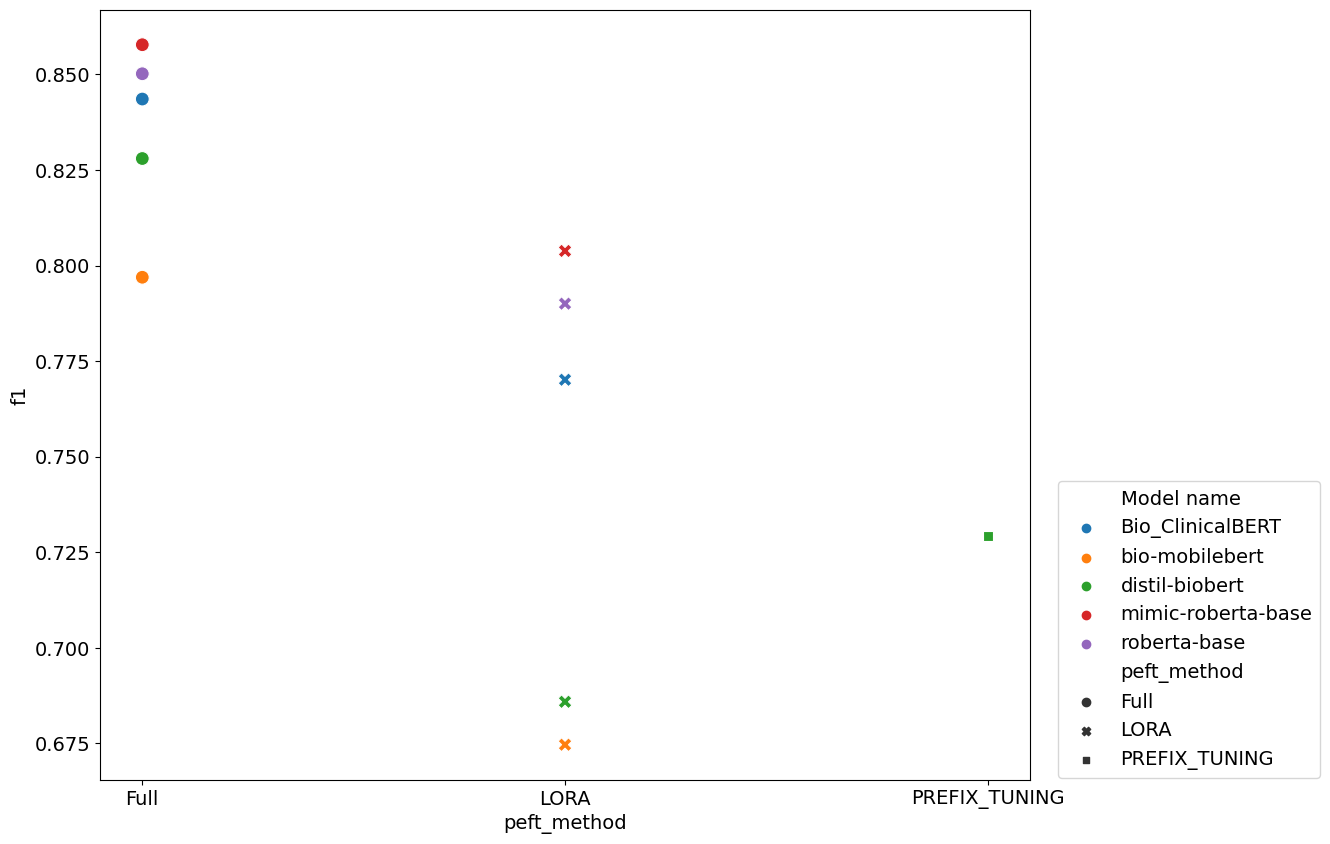

<Figure size 1200x1000 with 0 Axes>

In [19]:

task = "i2b2-2010-NER"

sample_sizes = sorted(set(cls_results_df['few_shot_n'].unique()))
sample_size_x_ticks = [str(x) for x in sample_sizes]

metric = "f1"

# scatter plot for roberta base vs few shot n with hue as peft method
plt.figure(figsize=(12,10))

fig, ax = plt.subplots(figsize=(12,10))
g = sns.scatterplot(data = cls_results_df.query("task == @task & `Model name` in @models_of_interest"),
                    x = "peft_method",
                    y = metric,
                    hue = "Model name",
                    style = "peft_method",
                    s = 100, ax = ax,
                    )

# do same again with point plot

plt.figure(figsize=(12,10))
g = sns.lineplot(data = cls_results_df.query("task == @task & `Model name` in @models_of_interest"),
                        x = "peft_method",
                        y = metric,
                        hue = "Model name",
                        style = "peft_method",
                        ax =ax, 
                        legend = False
)


sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))



### Can also look at averages across tasks

not sure if good idea or not, but may be useful to look at averages across tasks

In [ ]:
results_df = produce_results_table(logs_df, 
                                        metric = ["f1_macro","accuracy"],
                                        mode = "eval",
                                        groupby_list = ["Model name", "few_shot_n", "peft_method"],
                                        tasks = ["icd9-triage-no-category-in-text","mimic-mp"],
                                        value_aggregate_method = "max",
                                        )

#### random debugging

In [103]:
from scipy.special import softmax as sk_softmax
# load softmax from pytorch
from torch.nn.functional import softmax

In [104]:
faulty_logits =  [26443.322, 26029.15, 23799.176, 12593.839, 22744.002, 20037.562, 30538.14, 21639.273, 30558.88]

In [106]:
np.sum(sk_softmax(faulty_logits))

1.0000000000011509

In [119]:
import evaluate

In [84]:
# convert faulty logits to tensor
logits = torch.tensor(faulty_logits)

In [88]:
logits

tensor([26443.3223, 26029.1504, 23799.1758, 12593.8389, 22744.0020, 20037.5625,
        30538.1406, 21639.2734, 30558.8809])

In [87]:
sk_softmax(logits)

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.8317e-10, 0.0000e+00, 1.0000e+00])

In [86]:
softmax(logits)

/tmp/ipykernel_39749/3615344952.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(logits)


tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.8317e-10, 0.0000e+00, 1.0000e+00])

In [97]:
working_logits = [25719.342, 25567.707, 23205.53, 12138.746, 22023.115, 19547.37, 29444.035, 21317.316, 29743.26]

In [96]:
softmax(torch.tensor(working_logits))

/tmp/ipykernel_39749/2639681039.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(torch.tensor(working_logits))


tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [94]:
np.max(faulty_logits)

30558.88

In [93]:
working_logits

[25719.342,
 25567.707,
 23205.53,
 12138.746,
 22023.115,
 19547.37,
 29444.035,
 21317.316,
 29743.26]

In [107]:
from torchmetrics import AUROC

In [128]:
# faulty labels

faulty_labels = np.zeros_like(faulty_logits)
faulty_labels[5] = 1

In [181]:
auroc = AUROC(task =  "binary", threshold = 0.5)
multi_auroc = AUROC(task = "multiclass", num_classes=9)

In [118]:
faulty_logits

[26443.322,
 26029.15,
 23799.176,
 12593.839,
 22744.002,
 20037.562,
 30538.14,
 21639.273,
 30558.88]

In [117]:
auroc(torch.tensor((faulty_logits)), torch.tensor(faulty_labels))

/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


tensor(0.)

In [177]:
hf_roc_auc = evaluate.load("roc_auc", "multiclass")

In [123]:
faulty_scores = sk_softmax(faulty_logits)

In [125]:
faulty_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [124]:
faulty_scores

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.83405074e-10, 0.00000000e+00,
       9.99999999e-01])

In [130]:
hf_roc_auc.compute(references=faulty_labels,
                                            prediction_scores = faulty_scores,
                                            multi_class = 'ovr', 
                                            average = "macro")['roc_auc']

0.375

In [139]:
import numpy as np

# Open file 
data = []
with open('../faulty_logits.txt') as f:
  # Read lines
  lines = f.read().split('\n')

data = [d.split(',') for d in lines]
data = np.array(data, dtype=np.float32)
print(data)

[[26443.322 26029.15  23799.176 ... 30538.14  21639.273 30558.88 ]
 [25855.453 25518.928 23285.416 ... 29789.299 21231.01  29885.418]
 [26724.164 26196.896 24030.08  ... 30973.979 21752.494 30876.074]
 ...
 [20373.922 19027.521 18072.285 ... 24537.35  15531.233 23401.838]
 [28499.885 27426.361 25497.64  ... 33555.13  22613.291 32864.805]
 [24578.404 23902.756 22054.492 ... 28687.58  19786.752 28377.973]]


In [158]:

faulty_labels = np.random.randint(0, len(data[0]), size=len(data))


In [162]:
faulty_labels.max()

8

In [144]:
faulty_labels.shape

(43000, 9)

In [170]:
faulty_scores = sk_softmax(data, axis = -1)

In [171]:
faulty_scores

array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 9.831747e-10,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.803471e-42,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 3.026805e-43],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00]], dtype=float32)

In [172]:
faulty_scores.shape

(43000, 9)

In [174]:
faulty_labels

(43000,)

In [186]:
torch.tensor(faulty_scores).shape

torch.Size([43000, 9])

In [187]:
multi_auroc(torch.tensor(faulty_scores), torch.tensor(faulty_labels))

tensor(0.5000)

In [178]:
hf_roc_auc.compute(references=faulty_labels,
                    prediction_scores = faulty_scores,
                    multi_class = 'ovr', 
                    average = "macro")['roc_auc']

ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes